In [2]:
# Metabook pg. 98
# Using A3 for constants

import numpy as math
import matplotlib.pyplot as plt

W_P = 8.5
W_S = 15.8
W_initial = 6409
P_guess = W_initial / W_P
S_guess = W_initial / W_S
A = 0.74  # Regression constants from Martin's Metabook which cites it from Raymer (2006, Table 3.1)
C = -0.03

c_sl = 0.16 # specific fuel consumtion factor in lb / hp-hr # float(input("Enter the value of c_SL: "))  # Algorithm 3 pg. 50 Metabook
S_wet_initial = 1458
S_wet_initial_rest = S_wet_initial - (2*56*6)
c_cr = 0.22
weight_crew = 180
weight_payload = 2000

V = 250 * 1.688
rho = 0.00238
cL_max_takeoff = 1.7 # CHECK #float(input("Enter the cL_max of the wing: ")) #Needs to be approximated based on historical data
cL_max_cruise = 1.6 # CHECK
cL_max_landing = 1.8 # CHECK
V_stall = 52 * 1.688# ft/s approximation - stall speed of a small aircraft # math.sqrt((2 * W_0) / (rho * S_ref * cL_max)) #float(input("Enter the stall velocity (ft/s): "))

s_to = 1500 # RFP #float(input("Enter the takeoff distance (ft): "))
a = 0.0149 
b = 8.134 
discriminant = b**2 - 4*a*(-s_to)
top23 = (-b + math.sqrt(discriminant)) / (2*a)
rho_condition = 0.0023672

s_a = 600 # ft - from Raymer's text pg. 138
s_landing = 1500 # in ft

eta_p = 0.95
c = 1.0447 # Source - Gama
d = 0.5326 # Source - Gama
c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
G3 = 0.083
V_climb = V_stall * 1.1
q_climb = 0.5 * rho * (V_climb)**2
eff_clean = 0.825

V_balked = V_stall * 1.15
q_baled = 0.5 * rho * (V_balked)**2
G1 = 0.03

n = 2 # float(input("Enter the load factor (#g): "))
V_mn = V * 0.5
q_maneuver = 0.5 * rho_condition * V_mn**2

v_cruise = V * 0.5
q_cruise = 0.5 * rho_condition * v_cruise**2

V_ceiling = V * 0.5
Gceiling = (100 / 60) / V_ceiling
q_ceiling = 0.5 * rho * (V_ceiling)**2

def stall_WS():
    WS_stall = (1/2) * (rho) * (V_stall)**2 * cL_max_landing
    return WS_stall

def landing_WS():
    WS_landing = ( (s_landing - s_a) / 80 ) * ((rho_condition / rho) * cL_max_landing)
    return WS_landing

def takeoff(WS): 
    power_weight_ratio_takeoff = WS / ((rho_condition / rho) * cL_max_takeoff * top23)
    return power_weight_ratio_takeoff

def climb(WS, cd_0, AR):
    power_weight_ratio_climb2 = ((V_climb) * (G3 + ((q_climb * cd_0 / WS) + (WS / (AR * math.pi * eff_clean * q_climb))))) / 550
    return power_weight_ratio_climb2

def balked_climb(WS, cd_0, AR):
    power_weight_ratio_climb4 = ((V_balked) * (G1 + ((q_baled * cd_0 / WS) + (WS / (AR * math.pi * eff_clean * q_baled))))) / 550
    return power_weight_ratio_climb4

def maneuver(WS, cd_0, AR):
    power_weight_ratio_maneuver2 = ((V_mn) * ((q_maneuver * cd_0 / WS) + (WS * (n**2) / (AR * math.pi * eff_clean * q_maneuver)))) / 550
    return power_weight_ratio_maneuver2

def cruise(WS, cd_0, AR):
    power_weight_ratio_cruise = ((q_cruise * v_cruise * (cd_0 + ((WS**2)*(0.956**2) / ((q_cruise**2) * math.pi * AR * eff_clean)))) / (550 * WS)) / 0.75 # metabook pg. 43
    return power_weight_ratio_cruise

def ceiling(WS, cd_0, AR):
    power_weight_ratio_ceiling2 = ((V_ceiling) * (Gceiling + ((q_ceiling * cd_0 / WS) + (WS / (AR * math.pi * eff_clean * q_ceiling))))) / 550
    return power_weight_ratio_ceiling2

def weight_exp(W0):
    weight = A * ((W0**C))
    return weight

S_range = math.linspace(1, 651, 5001)
P_range = math.linspace(1, 1201, 5001)
S_ST = math.ones(5001)
S_LD = math.ones(5001)
P_TO = math.ones(5001)
P_CL = math.ones(5001)
P_BC = math.ones(5001)
P_MN = math.ones(5001)
P_CR = math.ones(5001)
P_CE = math.ones(5001)

stall_con = math.ones(5001)
landing_con = math.ones(5001)
takeoff_con = math.ones(5001)
climb_con = math.ones(5001)
balked_climb_con = math.ones(5001)
maneuver_con = math.ones(5001)
cruise_con = math.ones(5001)
ceiling_con = math.ones(5001)

#balked_climb_con[i] = balked_climb(W0_S0, parasite_drag_coeff, AR_iter) * W0
#maneuver_con[i] = maneuver(W0_S0, parasite_drag_coeff, AR_iter) * W0
#cruise_con[i] = cruise(W0_S0, parasite_drag_coeff, AR_iter) * W0
#ceiling_con[i] = ceiling(W0_S0, parasite_drag_coeff, AR_iter) * W0

In [3]:
for i in range(5001):
    S0 = S_range[i]
    P_TO[i] = P_guess
    tolerance = 0.1
    converged = False
    tol = 2e-6
    while converged == False:
        W0 = 6409
        weight_tol = 1e-6
        while tol > weight_tol:
            We_W0 = weight_exp(W0)
            We = We_W0 * W0
            density_wing = 2.5  # lb/ft^2 Metabook pg. 76
            S_initial = W0/W_S
            P_initial = W0/W_P
            We += density_wing * (S0 - S_initial)
            W_engine_dp = (P_initial ** 0.9306) * (10 ** -0.1205) # Metabook 79
            W_engine = (P_TO[i] ** 0.9306) * (10 ** -0.1205)
            We += (W_engine) - (W_engine_dp)

            # Algorithm 3 - fuel fraction calculation
            T_inital = P_guess * 550 / (V_climb)
            W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
            W1 = W1_W0 * W0
            W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
            W3_W2 = 0.985  # climb segment in Algorithm 3 - using historical values

            c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
            eff_clean = 0.825  # Oswald efficiency factor
            AR = (56**2)/S0  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

            CD_0 = c_f * (S_wet_initial_rest + (2 * S0)) / S0  # Zero-lift drag coefficient
            k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
            CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
            L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio
            
            W4_W3 = math.exp(-(600 * 1.151) * c_cr / (125 * 1.151 * L_D))  # weight fraction during cruising

            W5_W4 = 0.99  # Descent historical value
            W6_W5 = 0.995  # Landing historical value

            W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0

            Wf_W0 = 1 - W6_W0
            W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - (We/W0))  # calculating the new takeoff gross weight
            newtol = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
            tol = newtol
            W0 = W0_new  # updating the takeoff gross weight
        W0_S0 = W0_new / S0
        S_wet = (10 ** c) * (W0_new ** d)# 4605 * 142.45 # float(input("Enter the reference wing wet area (ft^2): "))
        S_wet_S_ref =  S_wet / S0 # 4 - from Raymer's text
        parasite_drag_coeff = c_f * S_wet_S_ref
        takeoff_con[i] = takeoff(W0_S0) * W0_new
        if abs(takeoff_con[i] - P_TO[i]) <= tolerance:
            converged = True
        P_TO[i] = takeoff_con[i]



In [4]:
for i in range(5001):
    S0 = S_range[i]
    P_CL[i] = P_guess
    tolerance = 0.1
    converged = False
    tol = 2e-6
    while converged == False:
        W0 = 6409
        weight_tol = 1e-6
        while tol > weight_tol:
            We_W0 = weight_exp(W0)
            We = We_W0 * W0
            density_wing = 2.5  # lb/ft^2 Metabook pg. 76
            S_initial = W0/W_S
            P_initial = W0/W_P
            We += density_wing * (S0 - S_initial)
            W_engine_dp = (P_initial ** 0.9306) * (10 ** -0.1205) # Metabook 79
            W_engine = (P_CL[i] ** 0.9306) * (10 ** -0.1205)
            We += (W_engine) - (W_engine_dp)

            # Algorithm 3 - fuel fraction calculation
            T_inital = P_guess * 550 / (V_climb)
            W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
            W1 = W1_W0 * W0
            W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
            W3_W2 = 0.985  # climb segment in Algorithm 3 - using historical values

            c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
            eff_clean = 0.825  # Oswald efficiency factor
            AR = (56**2)/S0  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

            CD_0 = c_f * (S_wet_initial_rest + (2 * S0)) / S0  # Zero-lift drag coefficient
            k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
            CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
            L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

            W4_W3 = math.exp(-(600 * 1.151) * c_cr / (125 * 1.151 * L_D))  # weight fraction during cruising

            W5_W4 = 0.99  # Descent historical value
            W6_W5 = 0.995  # Landing historical value

            W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
            Wf_W0 = 1 - W6_W0

            W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - (We/W0))  # calculating the new takeoff gross weight
            newtol = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
            tol = newtol
            W0 = W0_new  # updating the takeoff gross weight
        W0_S0 = W0_new / S0
        S_wet = (10 ** c) * (W0_new ** d)# 4605 * 142.45 # float(input("Enter the reference wing wet area (ft^2): "))
        S_wet_S_ref =  S_wet / S0 # 4 - from Raymer's text
        parasite_drag_coeff = c_f * S_wet_S_ref
        climb_con[i] = climb(W0_S0, parasite_drag_coeff, (56**2)/S0) * W0_new
        if abs(climb_con[i] - P_CL[i]) <= tolerance:
            converged = True
        P_CL[i] = climb_con[i]

In [5]:
for i in range(5001):
    S0 = S_range[i]
    P_BC[i] = P_guess
    tolerance = 0.1
    converged = False
    tol = 2e-6
    while converged == False:
        W0 = 6409
        weight_tol = 1e-6
        while tol > weight_tol:
            We_W0 = weight_exp(W0)
            We = We_W0 * W0
            density_wing = 2.5  # lb/ft^2 Metabook pg. 76
            S_initial = W0/W_S
            P_initial = W0/W_P
            We += density_wing * (S0 - S_initial)
            W_engine_dp = (P_initial ** 0.9306) * (10 ** -0.1205) # Metabook 79
            W_engine = (P_BC[i] ** 0.9306) * (10 ** -0.1205)
            We += (W_engine) - (W_engine_dp)

            # Algorithm 3 - fuel fraction calculation
            T_inital = P_guess * 550 / (V_climb)
            W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
            W1 = W1_W0 * W0
            W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
            W3_W2 = 0.985  # climb segment in Algorithm 3 - using historical values

            c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
            eff_clean = 0.825  # Oswald efficiency factor
            AR = (56**2)/S0  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

            CD_0 = c_f * (S_wet_initial_rest + (2 * S0)) / S0  # Zero-lift drag coefficient
            k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
            CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
            L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

            W4_W3 = math.exp(-(600 * 1.151) * c_cr / (125 * 1.151 * L_D))  # weight fraction during cruising

            W5_W4 = 0.99  # Descent historical value
            W6_W5 = 0.995  # Landing historical value

            W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
            Wf_W0 = 1 - W6_W0

            W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - (We/W0))  # calculating the new takeoff gross weight
            newtol = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
            tol = newtol
            W0 = W0_new  # updating the takeoff gross weight
        W0_S0 = W0_new / S0
        S_wet = (10 ** c) * (W0_new ** d)# 4605 * 142.45 # float(input("Enter the reference wing wet area (ft^2): "))
        S_wet_S_ref =  S_wet / S0 # 4 - from Raymer's text
        parasite_drag_coeff = c_f * S_wet_S_ref
        balked_climb_con[i] = balked_climb(W0_S0, parasite_drag_coeff, (56**2)/S0) * W0_new
        if abs(balked_climb_con[i] - P_BC[i]) <= tolerance:
            converged = True
        P_BC[i] = balked_climb_con[i]

In [6]:
for i in range(5001):
    S0 = S_range[i]
    P_MN[i] = P_guess
    tolerance = 0.1
    converged = False
    tol = 2e-6
    while converged == False:
        W0 = 6409
        weight_tol = 1e-6
        while tol > weight_tol:
            We_W0 = weight_exp(W0)
            We = We_W0 * W0
            density_wing = 2.5  # lb/ft^2 Metabook pg. 76
            S_initial = W0/W_S
            P_initial = W0/W_P
            We += density_wing * (S0 - S_initial)
            W_engine_dp = (P_initial ** 0.9306) * (10 ** -0.1205) # Metabook 79
            W_engine = (P_MN[i] ** 0.9306) * (10 ** -0.1205)
            We += (W_engine) - (W_engine_dp)

            # Algorithm 3 - fuel fraction calculation
            T_inital = P_guess * 550 / (V_climb)
            W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
            W1 = W1_W0 * W0
            W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
            W3_W2 = 0.985  # climb segment in Algorithm 3 - using historical values

            c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
            eff_clean = 0.825  # Oswald efficiency factor
            AR = (56**2)/S0  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

            CD_0 = c_f * (S_wet_initial_rest + (2 * S0)) / S0  # Zero-lift drag coefficient
            k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
            CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
            L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

            W4_W3 = math.exp(-(600 * 1.151) * c_cr / (125 * 1.151 * L_D))  # weight fraction during cruising

            W5_W4 = 0.99  # Descent historical value
            W6_W5 = 0.995  # Landing historical value

            W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
            Wf_W0 = 1 - W6_W0

            W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - (We/W0))  # calculating the new takeoff gross weight
            newtol = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
            tol = newtol
            W0 = W0_new  # updating the takeoff gross weight
        W0_S0 = W0_new / S0
        S_wet = (10 ** c) * (W0_new ** d)# 4605 * 142.45 # float(input("Enter the reference wing wet area (ft^2): "))
        S_wet_S_ref =  S_wet / S0 # 4 - from Raymer's text
        parasite_drag_coeff = c_f * S_wet_S_ref
        maneuver_con[i] = maneuver(W0_S0, parasite_drag_coeff, (56**2)/S0) * W0_new
        if abs(maneuver_con[i] - P_MN[i]) <= tolerance:
            converged = True
        P_MN[i] = maneuver_con[i]

In [7]:
for i in range(5001):
    S0 = S_range[i]
    P_CR[i] = P_guess
    tolerance = 0.1
    converged = False
    tol = 2e-6
    while converged == False:
        W0 = 6409
        weight_tol = 1e-6
        while tol > weight_tol:
            We_W0 = weight_exp(W0)
            We = We_W0 * W0
            density_wing = 2.5  # lb/ft^2 Metabook pg. 76
            S_initial = W0/W_S
            P_initial = W0/W_P
            We += density_wing * (S0 - S_initial)
            W_engine_dp = (P_initial ** 0.9306) * (10 ** -0.1205) # Metabook 79
            W_engine = (P_CR[i] ** 0.9306) * (10 ** -0.1205)
            We += (W_engine) - (W_engine_dp)

            # Algorithm 3 - fuel fraction calculation
            T_inital = P_guess * 550 / (V_climb)
            W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
            W1 = W1_W0 * W0
            W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
            W3_W2 = 0.985  # climb segment in Algorithm 3 - using historical values

            c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
            eff_clean = 0.825  # Oswald efficiency factor
            AR = (56**2)/S0  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

            CD_0 = c_f * (S_wet_initial_rest + (2 * S0)) / S0  # Zero-lift drag coefficient
            k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
            CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
            L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

            W4_W3 = math.exp(-(600 * 1.151) * c_cr / (125 * 1.151 * L_D))  # weight fraction during cruising

            W5_W4 = 0.99  # Descent historical value
            W6_W5 = 0.995  # Landing historical value

            W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
            Wf_W0 = 1 - W6_W0

            W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - (We/W0))  # calculating the new takeoff gross weight
            newtol = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
            tol = newtol
            W0 = W0_new  # updating the takeoff gross weight
        W0_S0 = W0_new / S0
        S_wet = (10 ** c) * (W0_new ** d)# 4605 * 142.45 # float(input("Enter the reference wing wet area (ft^2): "))
        S_wet_S_ref =  S_wet / S0 # 4 - from Raymer's text
        parasite_drag_coeff = c_f * S_wet_S_ref
        cruise_con[i] = cruise(W0_S0, parasite_drag_coeff, (56**2)/S0) * W0_new
        if abs(cruise_con[i] - P_CR[i]) <= tolerance:
            converged = True
        P_CR[i] = cruise_con[i]

In [8]:
for i in range(5001):
    S0 = S_range[i]
    P_CE[i] = P_guess
    tolerance = 0.1
    converged = False
    tol = 2e-6
    while converged == False:
        W0 = 6409
        weight_tol = 1e-6
        while tol > weight_tol:
            We_W0 = weight_exp(W0)
            We = We_W0 * W0
            density_wing = 2.5  # lb/ft^2 Metabook pg. 76
            S_initial = W0/W_S
            P_initial = W0/W_P
            We += density_wing * (S0 - S_initial)
            W_engine_dp = (P_initial ** 0.9306) * (10 ** -0.1205) # Metabook 79
            W_engine = (P_CE[i] ** 0.9306) * (10 ** -0.1205)
            We += (W_engine) - (W_engine_dp)

            # Algorithm 3 - fuel fraction calculation
            T_inital = P_initial * 550 / (V_climb)
            W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
            W1 = W1_W0 * W0
            W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
            W3_W2 = 0.985  # climb segment in Algorithm 3 - using historical values

            c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
            eff_clean = 0.825  # Oswald efficiency factor
            AR = (56**2)/S0  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

            CD_0 = c_f * (S_wet_initial_rest + (2 * S0)) / S0  # Zero-lift drag coefficient
            k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
            CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
            L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

            W4_W3 = math.exp(-(600 * 1.151) * c_cr / (125 * 1.151 * L_D))  # weight fraction during cruising

            W5_W4 = 0.99  # Descent historical value
            W6_W5 = 0.995  # Landing historical value

            W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
            Wf_W0 = 1 - W6_W0

            W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - (We/W0))  # calculating the new takeoff gross weight
            newtol = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
            tol = newtol
            W0 = W0_new  # updating the takeoff gross weight
        W0_S0 = W0_new / S0
        S_wet = (10 ** c) * (W0_new ** d)# 4605 * 142.45 # float(input("Enter the reference wing wet area (ft^2): "))
        S_wet_S_ref =  S_wet / S0 # 4 - from Raymer's text
        parasite_drag_coeff = c_f * S_wet_S_ref
        ceiling_con[i] = ceiling(W0_S0, parasite_drag_coeff, (56**2)/S0) * W0_new
        if abs(ceiling_con[i] - P_CE[i]) <= tolerance:
            converged = True
        P_CE[i] = ceiling_con[i]

In [9]:
for i in range(5001):
    P0 = P_range[i]
    S_ST[i] = S_guess
    tolerance = 0.1
    converged = False
    tol = 2e-6
    tol = 2e-6
    while converged == False:
        W0 = 6409
        weight_tol = 1e-6
        while tol > weight_tol:
            We_W0 = weight_exp(W0)
            We = We_W0 * W0
            density_wing = 2.5  # lb/ft^2 Metabook pg. 76
            S_initial = W0/W_S
            P_initial = W0/W_P
            We += density_wing * (S_ST[i] - S_initial)
            W_engine_dp = (S_ST[i] ** 0.9306) * (10 ** -0.1205) # Metabook 79
            W_engine = (P0 ** 0.9306) * (10 ** -0.1205)
            We += (W_engine) - (W_engine_dp)

            # Algorithm 3 - fuel fraction calculation
            T_inital = P0 * 550 / (V_climb)
            W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
            W1 = W1_W0 * W0
            W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
            W3_W2 = 0.985  # climb segment in Algorithm 3 - using historical values

            c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
            eff_clean = 0.825  # Oswald efficiency factor
            AR = (56**2)/S_ST[i]  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

            CD_0 = c_f * (S_wet_initial_rest + (2 * S_ST[i])) / S_ST[i]  # Zero-lift drag coefficient
            k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
            CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
            L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

            W4_W3 = math.exp(-(600 * 1.151) * c_cr / (125 * 1.151 * L_D))  # weight fraction during cruising

            W5_W4 = 0.99  # Descent historical value
            W6_W5 = 0.995  # Landing historical value

            W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
            Wf_W0 = 1 - W6_W0

            W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - (We/W0))  # calculating the new takeoff gross weight
            newtol = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
            tol = newtol
            W0 = W0_new  # updating the takeoff gross weight
        stall_con[i] = (stall_WS() / W0_new) **(-1)
        if abs(stall_con[i] - S_ST[i]) <= tolerance:
            converged = True
        S_ST[i] = stall_con[i]

In [10]:
for i in range(5001):
    P0 = P_range[i]
    S_LD[i] = S_guess
    tolerance = 0.1
    converged = False
    tol = 2e-6
    tol = 2e-6
    while converged == False:
        W0 = 6409
        weight_tol = 1e-6
        while tol > weight_tol:
            We_W0 = weight_exp(W0)
            We = We_W0 * W0
            density_wing = 2.5  # lb/ft^2 Metabook pg. 76
            S_initial = W0/W_S
            P_initial = W0/W_P
            We += density_wing * (S_LD[i] - S_initial)
            W_engine_dp = (S_LD[i] ** 0.9306) * (10 ** -0.1205) # Metabook 79
            W_engine = (P0 ** 0.9306) * (10 ** -0.1205)
            We += (W_engine) - (W_engine_dp)

            # Algorithm 3 - fuel fraction calculation
            T_inital = P0 * 550 / (V_climb)
            W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
            W1 = W1_W0 * W0
            W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
            W3_W2 = 0.985  # climb segment in Algorithm 3 - using historical values

            c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
            eff_clean = 0.825  # Oswald efficiency factor
            AR = (56**2)/S_LD[i]  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

            CD_0 = c_f * (S_wet_initial_rest + (2 * S_LD[i])) / S_LD[i]  # Zero-lift drag coefficient
            k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
            CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
            L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

            W4_W3 = math.exp(-(600 * 1.151) * c_cr / (125 * 1.151 * L_D))  # weight fraction during cruising

            W5_W4 = 0.99  # Descent historical value
            W6_W5 = 0.995  # Landing historical value

            W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
            Wf_W0 = 1 - W6_W0

            W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - (We/W0))  # calculating the new takeoff gross weight
            newtol = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
            tol = newtol
            W0 = W0_new  # updating the takeoff gross weight
        landing_con[i] = (landing_WS() / W0_new) **(-1)
        if abs(landing_con[i] - S_LD[i]) <= tolerance:
            converged = True
        S_LD[i] = landing_con[i]

/var/folders/_m/6r3r9r4d1cs6rbs568htxt040000gn/T/ipykernel_58729/2435084043.py:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lH in legendcol.legendHandles:


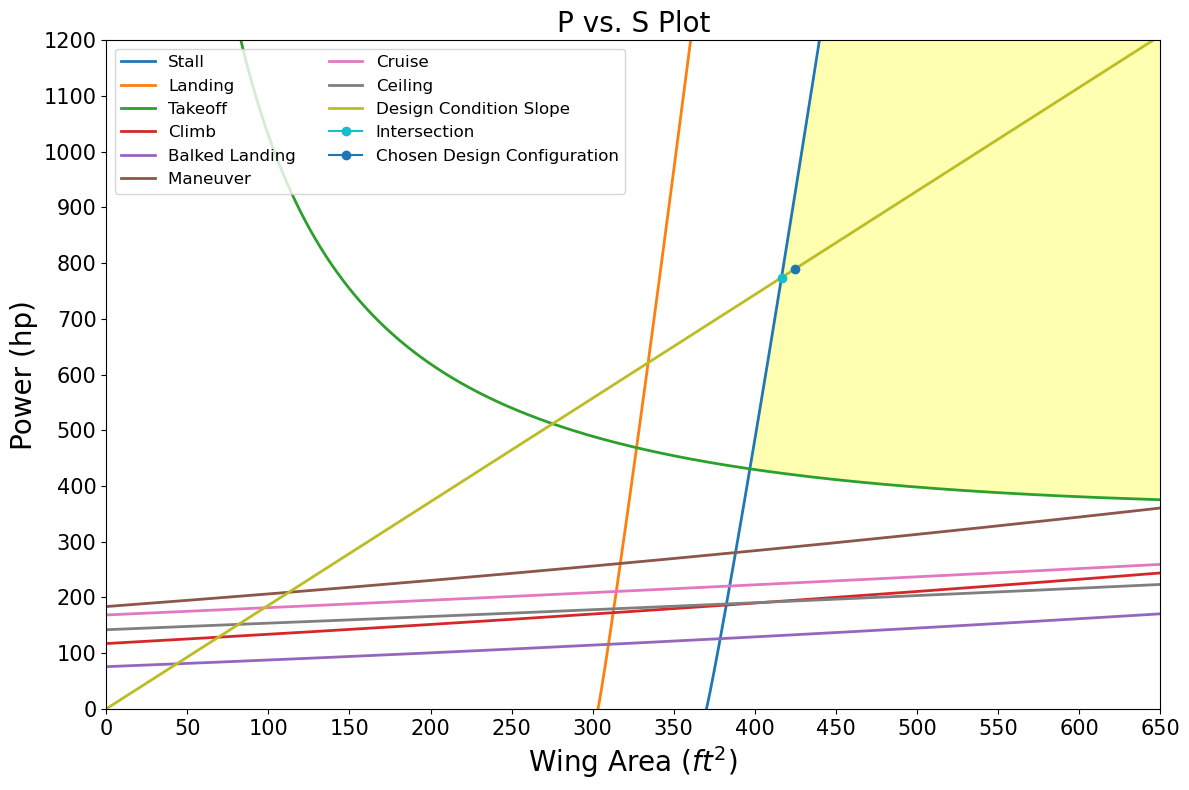

In [11]:
plt.figure(figsize=(12,8))
plt.title('P vs. S Plot', fontsize=20)
plt.xlabel("Wing Area $(ft^2)$", fontsize=20)
plt.ylabel("Power (hp)", fontsize=20)
plt.plot(S_ST, P_range, label='Stall', linestyle='-', linewidth=2)
plt.plot(S_LD, P_range, label='Landing', linestyle='-', linewidth=2)
plt.plot(S_range, P_TO, label='Takeoff', linestyle='-', linewidth=2)
plt.plot(S_range, P_CL, label='Climb', linestyle='-', linewidth=2)
plt.plot(S_range, P_BC, label='Balked Landing', linestyle='-', linewidth=2)
plt.plot(S_range, P_MN, label='Maneuver ', linestyle='-', linewidth=2)
plt.plot(S_range, P_CR, label='Cruise', linestyle='-', linewidth=2)
plt.plot(S_range, P_CE, label='Ceiling', linestyle='-', linewidth=2)
plt.plot(S_range, S_range * (15.8 / 8.5), label='Design Condition Slope', linestyle='-', linewidth=2)
plt.plot(416.48, 416.4874 * (15.8 / 8.5), label='Intersection', marker="o")
plt.plot(425, 425 * (15.8 / 8.5), label='Chosen Design Configuration', marker="o")
#print(S_range[math.where(P_TO == (min(P_TO)))])
#print(min(P_TO))
plt.fill_between(S_range[3050:], P_TO[3050:], (17.2 * S_range[3050:]) - 6400 , color='yellow', alpha=0.3)

plt.ylim(0, 1200)
plt.xlim(1,650)
plt.yticks(math.arange(0, 1300, step=100), fontsize=15)
plt.xticks(math.arange(0, 700, step=50), fontsize=15)


plt.legend(loc=9)
plt.tight_layout()
legendcol = plt.legend(ncol=2, fontsize=12)
for lH in legendcol.legendHandles:
  if lH.get_linestyle=="None":
     lH.set_visible=False 
plt.show()


/var/folders/_m/6r3r9r4d1cs6rbs568htxt040000gn/T/ipykernel_58729/4281237632.py:33: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lH in legendcol.legendHandles:


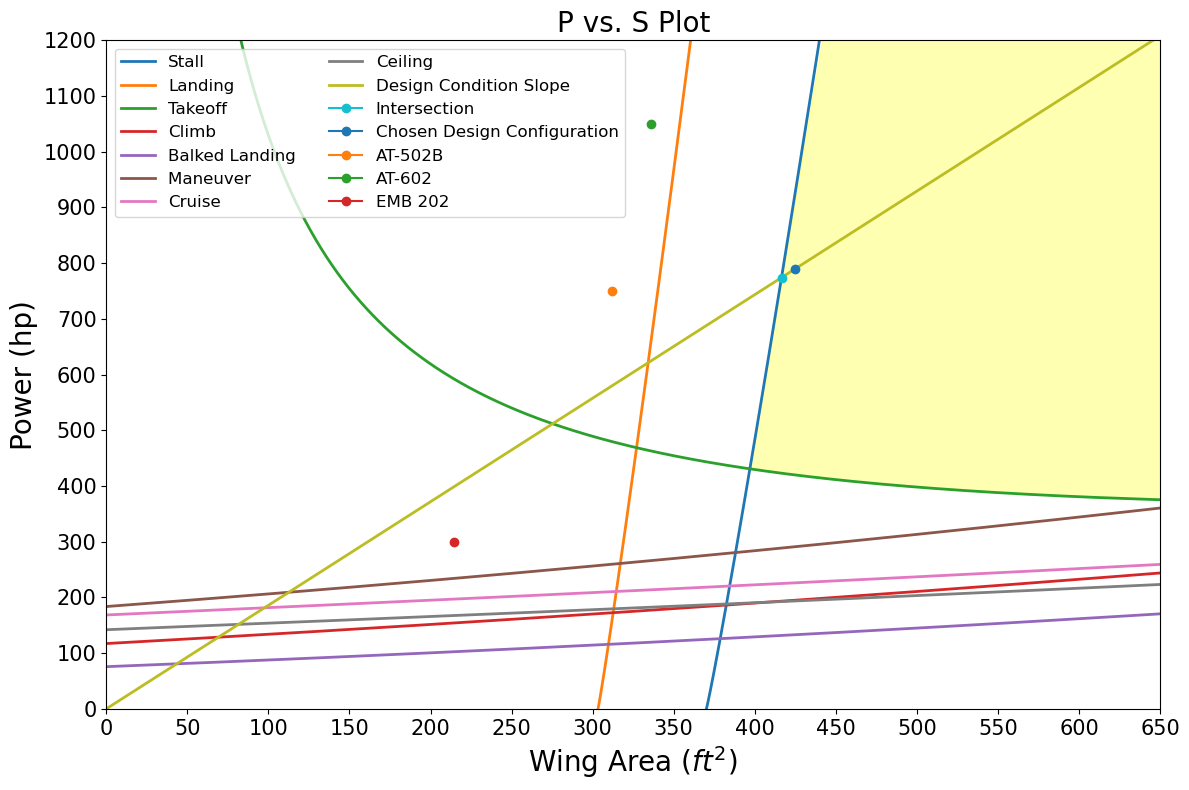

In [12]:
plt.figure(figsize=(12,8))
plt.title('P vs. S Plot', fontsize=20)
plt.xlabel("Wing Area $(ft^2)$", fontsize=20)
plt.ylabel("Power (hp)", fontsize=20)
plt.plot(S_ST, P_range, label='Stall', linestyle='-', linewidth=2)
plt.plot(S_LD, P_range, label='Landing', linestyle='-', linewidth=2)
plt.plot(S_range, P_TO, label='Takeoff', linestyle='-', linewidth=2)
plt.plot(S_range, P_CL, label='Climb', linestyle='-', linewidth=2)
plt.plot(S_range, P_BC, label='Balked Landing', linestyle='-', linewidth=2)
plt.plot(S_range, P_MN, label='Maneuver ', linestyle='-', linewidth=2)
plt.plot(S_range, P_CR, label='Cruise', linestyle='-', linewidth=2)
plt.plot(S_range, P_CE, label='Ceiling', linestyle='-', linewidth=2)
plt.plot(S_range, S_range * (15.8 / 8.5), label='Design Condition Slope', linestyle='-', linewidth=2)
plt.plot(416.48, 416.4874 * (15.8 / 8.5), label='Intersection', marker="o")
plt.plot(425, 425 * (15.8 / 8.5), label='Chosen Design Configuration', marker="o")
plt.plot(312, 750, label='AT-502B', marker="o")
plt.plot(336, 1050, label='AT-602', marker="o")
plt.plot(214.6, 300, label='EMB 202', marker="o")

#print(S_range[math.where(P_TO == (min(P_TO)))])
#print(min(P_TO))
plt.fill_between(S_range[3050:], P_TO[3050:], (17.2 * S_range[3050:]) - 6400 , color='yellow', alpha=0.3)

plt.ylim(0, 1200)
plt.xlim(1,650)
plt.yticks(math.arange(0, 1300, step=100), fontsize=15)
plt.xticks(math.arange(0, 700, step=50), fontsize=15)


plt.legend(loc=9)
plt.tight_layout()
legendcol = plt.legend(ncol=2, fontsize=12)
for lH in legendcol.legendHandles:
  if lH.get_linestyle=="None":
     lH.set_visible=False 
plt.show()


In [13]:
S0 = 500
P0 = 500 * (15.8 / 8.5)
tolerance = 0.1
converged = False
tol = 2e-6
W0 = 6409
weight_tol = 1e-6
while tol > weight_tol:
    We_W0 = weight_exp(W0)
    We = We_W0 * W0
    density_wing = 2.5  # lb/ft^2 Metabook pg. 76
    We += density_wing * (S0)
    W_engine_dp = (P_initial ** 0.9306) * (10 ** -0.1205) # Metabook 79
    W_engine = (P0 ** 0.9306) * (10 ** -0.1205)
    We += (W_engine)

    # Algorithm 3 - fuel fraction calculation
    T_inital = P0 * 550 / (125*1.688)
    W1_W0 = 1 - c_sl * (15 / 60) * (0.05 * T_inital / W0)  # fuel burned from running the engine for 15 min at 5% max
    W1 = W1_W0 * W0
    W2_W1 = 1 - c_sl * (1 / 60) * (T_inital / W1)  # Fuel burned from running the engine for 1 min at max
    W3_W2 = 0.985  # climb segment in Algorithm 3 - using historical values

    c_f = 0.0055 # figure 4.4 on Metabook - "light aircraft - single engine"
    eff_clean = 0.825  # Oswald efficiency factor
    AR = (56**2)/S0  # Aspect ratio NEEDS TO CHANGE FOR CHANGE OF AIRCRAFT

    CD_0 = c_f * (S_wet_initial_rest + (2 * S0)) / S0  # Zero-lift drag coefficient
    k = 1 / (math.pi * eff_clean * AR)  # Induced drag factor
    CL = math.sqrt(CD_0 / k)  # Optimal CL for max L/D (Fix applied)
    L_D = (0.94 * CL) / (CD_0 + k * CL**2)  # Lift-to-drag ratio

    W4_W3 = math.exp(-(600 * 1.151) * c_sl / (125 * 1.688 * 3600 * L_D / 5280))  # weight fraction during cruising

    W5_W4 = 0.999  # Descent historical value
    W6_W5 = 0.998  # Landing historical value

    W6_W0 = W6_W5 * W5_W4 * W4_W3 * W3_W2 * W2_W1 * W1_W0
    Wf_W0 = 1 - W6_W0

    W0_new = (weight_crew + weight_payload) / (1 - Wf_W0 - (We/W0))  # calculating the new takeoff gross weight
    newtol = abs(W0_new - W0) / abs(W0_new)  # finding the difference between the last and current iteration of W0
    tol = newtol
    W0 = W0_new  # updating the takeoff gross weight
print(We)
print(W0_new)

7605.240475627332
10557.896830602405
